# Experiment template. 
## Note: 
template for experiments

In [1]:
# description = {here could be a short description of the experiment}

# specific name of the experiment
eval_name = 'allInoc_adadelta_unet2'

if eval_name is None:
    with open(path_to_dir+'eval_name.txt') as data_file:    
        eval_name = json.load(data_file)
print "eval_name is", eval_name 

eval_name is allInoc_adadelta_unet2


## The task is to predict number of lesions in the photo
***
### Content:
* [Settings and experiment parameters](#sep)
* [Load Data](#ld)
* [Learning and visualizing results](#lav)
* [Conclusions](#c)
***

#### Togle ON/OFF the raw code

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
CODE WAS HIDDEN. TO TOGGLE ON/OFF THE RAW CODE, CLICK
<a href="javascript:code_toggle()">here</a>.''')

---
<a name="sep"/>
# Settings and experiment parameters
</a>

In [2]:
%env THEANO_FLAGS="device=gpu0"

### Check theano ####
import theano

env: THEANO_FLAGS="device=gpu0"


Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5005)


### Global variables and paths 
* $\textbf{Add the main directory '.../code' to   sys.path}$. 

The following directory was added:

In [3]:
#### Add the main dir to sys ####

import os, sys

parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
print parentdir

sys.path.insert(0, parentdir)

/slowhome/makarova/columbia/code


In [4]:
%load_ext autoreload
%autoreload 2

* $\textbf{Put your certain values or None}$ (then use run.ipynb to set them outside).

Note: In case you put None, files with parameters should be in the same directory with this .ipynb file 
(else change path_to_dir by what ever you want)


In [5]:
TRAIN_NN = True

N_FILTERS = 32
BATCH_SIZE = 20
N_EPOCHS = 3000
N_BATCHES_PER_EPOCH = 10
N_BATCHES_PER_EPOCH_valid = 10
PATCH_SIZE = 256

In [6]:
# Read global params from files
import json

print "N_FILTERS = ", N_FILTERS
print "BATCH_SIZE = ", BATCH_SIZE
print "N_EPOCHS = ", N_EPOCHS
print "PATCH SIZE = ", PATCH_SIZE

N_FILTERS =  32
BATCH_SIZE =  20
N_EPOCHS =  3000
PATCH SIZE =  256


In [7]:
# txt files with paths to segmentation image and input image
txt_train = '/home/makarova/columbia/data/inoculated_1/gt_img_train_ellimg_small.txt'
txt_valid = '/home/makarova/columbia/data/inoculated_1/gt_img_valid_ellimg_small.txt'
txt_test = '/home/makarova/columbia/data/inoculated_1/gt_img_test_ellimg_small.txt'

from config import results_path
# path to save the results for THIS experiment
results_eval_path = results_path + eval_name + "/"

print txt_train
print txt_valid
print txt_test

print results_path

/home/makarova/columbia/data/inoculated_1/gt_img_train_ellimg_small.txt
/home/makarova/columbia/data/inoculated_1/gt_img_valid_ellimg_small.txt
/home/makarova/columbia/data/inoculated_1/gt_img_test_ellimg_small.txt
/home/makarova/columbia/code/results/


In [8]:
##### IMPORTS ####
import matplotlib
matplotlib.use('Pdf')

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

---
<a name='ld'/>
# Load Data
</a>

* Load and visualize data

In [9]:
from PIL import Image

def load_data(txt):
    
    imgs = []
    imgs_gt = []
    
    with open(txt, 'r') as fin:
        lines = fin.read().splitlines()
    for line in lines:
        imgs.append(line.split(' ')[1]) 
        imgs_gt.append(line.split(' ')[0])
    
    assert(len(imgs) == len(imgs_gt))
    imgs.sort()
    imgs_gt.sort()
    
    # images are 2000 by 3000 pixels each
    img_size = (2000, 3000)
    data = np.zeros((len(imgs), 3, img_size[0], img_size[1]), dtype=np.uint8)
    target = np.zeros((len(imgs), 1,  img_size[0], img_size[1]), dtype=np.uint8)
    
    ctr = 0
    for i, (im, gt_im) in enumerate(zip(imgs, imgs_gt)):
        data[ctr] = plt.imread(im).transpose((2, 0, 1))
        img = plt.imread(gt_im,0)
        target[ctr, 0] = img/255.
        ctr += 1
    return data, target

In [10]:
X_train, Y_train = load_data(txt_train)
X_valid, Y_valid = load_data(txt_valid)
X_test, Y_test = load_data(txt_test)

In [11]:
print X_train.shape
print Y_train.min()

(400, 3, 2000, 3000)
0


In [12]:
print X_train.max()

255


In [13]:
print Y_train.shape

(400, 1, 2000, 3000)


---
<a name='lav'/>
# Learning and Visualizing
</a>

In [14]:
from utils.generator import batch_generator, random_crop_generator, threaded_generator

* $ \textbf{ Characteristics of input images and the input layer}$

In [15]:
#### PREPARE DATA FOR NN ####

import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer

nmb_channels, inp_shape = X_train[0].shape[0], X_train[0].shape[1:]
print 'Image shape', inp_shape
print "Number of channels:", nmb_channels

X_inp = T.tensor4('X_inp')
X_layer = InputLayer([BATCH_SIZE, nmb_channels, PATCH_SIZE, PATCH_SIZE], \
                     input_var=X_inp,name='input')

print "Input layer shape:", X_layer.output_shape

Image shape (2000, 3000)
Number of channels: 3
Input layer shape: [20, 3, 256, 256]


# NN

In [16]:
from models.unet2 import uNet

In [17]:
import theano
import lasagne
from models.model import Model
from collections import OrderedDict
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer, Pool2DLayer, \
    ReshapeLayer, DimshuffleLayer, NonlinearityLayer, DropoutLayer, Upscale2DLayer
import theano.tensor as T
from lasagne.layers import batch_norm
from lasagne.regularization import regularize_network_params, l2


class uNet(Model):
    def __init__(self,
                 X_layer,
                 n_filters=32,
                 filter_size=3,
                 name='unet',
                 pad='same',
                 nmb_out_classes=2,
                 do_dropout=False):

        super(uNet, self).__init__(name)

        input_shape = X_layer.output_shape
        self.build_graph(input_shape, n_filters, filter_size, nmb_out_classes, do_dropout, pad)
        self.weights = lasagne.layers.get_all_params(self.net['output_flattened'], trainable=True)

        print self.net['output_segmentation'].output_shape, self.net['output_flattened'].output_shape

        self.pred_y = lasagne.layers.get_output(self.net['output_flattened'], X_layer.input_var)

        self.outlayer_for_loss = self.net['output_flattened']
        self.outlayer_seg = self.net['output_segmentation']

        if isinstance(X_layer, lasagne.layers.InputLayer):
            self.predict_fun = theano.function([X_layer.input_var], self.pred_y)

    def build_graph(self, input_shape, n_filters, filter_size, nmb_out_classes, do_dropout, pad='same'):

        nonlinearity = lasagne.nonlinearities.rectify
        self.net = OrderedDict()
        self.net['input'] = InputLayer(input_shape, name='input')
        print "Input: self.net['input']", self.net['input'].output_shape
        self.net['conv_1_1'] = Conv2DLayer(self.net['input'],
                                            num_filters=n_filters,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "\nConv11: self.net['conv_1_1']", self.net['conv_1_1'].output_shape
        self.net['dropout1'] = DropoutLayer(self.net['conv_1_1'], p=0.2)
        print "Dropout1: self.net['dropout1']", self.net['dropout1'].output_shape
        self.net['conv_1_2'] = Conv2DLayer(batch_norm(self.net['dropout1']),
                                            num_filters=n_filters,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv12: self.net['conv_1_2']", self.net['conv_1_2'].output_shape
        self.net['pool1'] = Pool2DLayer(batch_norm(self.net['conv_1_2']), 2)
        print "\nPool1: self.net['pool1']", self.net['pool1'].output_shape
        #
        self.net['conv_2_1'] = Conv2DLayer(batch_norm(self.net['pool1']),
                                            num_filters=n_filters * 2,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv21: self.net['conv_2_1']", self.net['conv_2_1'].output_shape
        self.net['dropout2'] = DropoutLayer(batch_norm(self.net['conv_2_1']), p=0.2)
        print "Dropout2: self.net['dropout2']", self.net['dropout2'].output_shape
        self.net['conv_2_2'] = Conv2DLayer(batch_norm(self.net['dropout2']),
                                            num_filters=n_filters * 2,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv22: self.net['conv_2_2']", self.net['conv_2_2'].output_shape
        self.net['pool2'] = Pool2DLayer(self.net['conv_2_2'], 2)
        print "\nPool2: self.net['pool2']", self.net['pool2'].output_shape
        #
        self.net['conv_3_1'] = Conv2DLayer(batch_norm(self.net['pool2']),
                                            num_filters=n_filters * 4,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv31: self.net['conv_3_1']", self.net['conv_3_1'].output_shape
        self.net['dropout3'] = DropoutLayer(self.net['conv_3_1'], p=0.2)
        print "Dropout3: self.net['dropout3']", self.net['dropout3'].output_shape
        self.net['conv_3_2'] = Conv2DLayer(batch_norm(self.net['dropout3']),
                                            num_filters=n_filters * 4,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv32: self.net['conv_3_2']", self.net['conv_3_2'].output_shape

#         self.net['pool3'] = Pool2DLayer(self.net['conv_3_2'], 2)
#         print "\nPool3: self.net['pool3']", self.net['pool3'].output_shape
#         #
#         self.net['conv_4_1'] = Conv2DLayer(batch_norm(self.net['pool3']),
#                                             num_filters=n_filters * 8,
#                                             filter_size=filter_size,
#                                             nonlinearity=nonlinearity,
#                                             pad=pad)
#         print "Conv41: self.net['conv_4_1']", self.net['conv_4_1'].output_shape
#         self.net['dropout4'] = DropoutLayer(self.net['conv_4_1'], p=0.2)
#         print "Dropout4: self.net['dropout4']", self.net['dropout4'].output_shape
#         self.net['conv_4_2'] = Conv2DLayer(batch_norm(self.net['dropout4']),
#                                             num_filters=n_filters * 8,
#                                             filter_size=filter_size,
#                                             nonlinearity=nonlinearity,
#                                             pad=pad)
#         print "Conv42: self.net['conv_4_2']", self.net['conv_4_2'].output_shape
        
        ##
        self.net['deconv1'] = Upscale2DLayer(batch_norm(self.net['conv_3_2']), 2)
        print "\nDeconv1: self.net['deconv1']", self.net['deconv1'].output_shape
        self.net['concat1'] = ConcatLayer([self.net['deconv1'], self.net['conv_2_2']],
                                          cropping=(None, None, "center", "center"))
        print "Concat1: self.net['concat1']",self.net['concat1'].output_shape
        self.net['expand_1_1'] = Conv2DLayer(self.net['concat1'],
                                             num_filters=n_filters * 4,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Expand11: self.net['expand_1_1']", self.net['expand_1_1'].output_shape
        self.net['expand_1_2'] = Conv2DLayer(batch_norm(self.net['expand_1_1']),
                                             num_filters=n_filters * 4,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Expand12: self.net['expand_1_2']", self.net['expand_1_2'].output_shape
        #
        self.net['deconv2'] = Upscale2DLayer(batch_norm(self.net['expand_1_2']), 2)
        print "\nDeconv2: self.net['deconv2']", self.net['deconv2'].output_shape
        self.net['concat2'] = ConcatLayer([self.net['deconv2'], self.net['conv_2_2']],
                                          cropping=(None, None, "center", "center"))
        print "Concat2: self.net['concat2']",self.net['concat2'].output_shape
        self.net['expand_2_1'] = Conv2DLayer(self.net['concat2'],
                                             num_filters=n_filters * 2,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Expand21: self.net['expand_2_1']", self.net['expand_2_1'].output_shape
        self.net['expand_2_2'] = Conv2DLayer(batch_norm(self.net['expand_2_1']),
                                             num_filters=n_filters * 2,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Expand22: self.net['expand_2_2']", self.net['expand_2_2'].output_shape
        #
        self.net['deconv3'] = Upscale2DLayer(batch_norm(self.net['expand_2_2']), 2)
        print "\nDeconv3: self.net['deconv3'] ", self.net['deconv3'] .output_shape
        self.net['concat3'] = ConcatLayer([self.net['deconv3'], self.net['conv_1_2']],
                                          cropping=(None, None, "center", "center"))
        print "Concat3: self.net['concat3']",self.net['concat3'].output_shape
        self.net['expand_3_1'] = Conv2DLayer(self.net['concat3'],
                                             num_filters=n_filters,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "\nExpand31: self.net['expand_3_1']", self.net['expand_3_1'].output_shape
        self.net['expand_3_2'] = Conv2DLayer(batch_norm(self.net['expand_3_1']),
                                             n_filters,
                                             filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Expand32: self.net['expand_3_2']", self.net['expand_3_2'].output_shape
        #
        self.net['output_segmentation'] = Conv2DLayer(self.net['expand_3_2'], 
                                                      nmb_out_classes, 
                                                      1, 
                                                      nonlinearity=lasagne.nonlinearities.sigmoid)
        print "self.net['output_segmentation']", self.net['output_segmentation'].output_shape

        self.net['dimshuffle'] = DimshuffleLayer(batch_norm(self.net['output_segmentation']), (1, 0, 2, filter_size))
        print "self.net['dimshuffle']", self.net['dimshuffle'].output_shape

        self.net['reshapeSeg'] = ReshapeLayer(self.net['dimshuffle'], (nmb_out_classes, -1))
        print "self.net['reshapeSeg']", self.net['reshapeSeg'].output_shape

        self.net['dimshuffle2'] = DimshuffleLayer(self.net['reshapeSeg'], (1, 0))
        print "self.net['dimshuffle2']", self.net['dimshuffle2'].output_shape

        self.net['output_flattened'] = NonlinearityLayer(self.net['reshapeSeg'],
                                                         nonlinearity=lasagne.nonlinearities.softmax)
        print "self.net['output_flattened']", self.net['output_flattened'].output_shape

    def predict(self, X, *args, **kwargs):
        """
        Input:  X
        """
        if not hasattr(self, 'predict_fun'):
            raise ValueError("you should add a valid predict_fun to this class"
                             "(no automatic predict generates since X_layer isn't an InputLayer")
        return self.predict_fun(X)

    def get_loss_components(self, target, weights):

        target = T.transpose(target)
        ce = lasagne.objectives.binary_crossentropy(self.pred_y, target)
        ce_weighed = lasagne.objectives.aggregate(ce, weights=weights, mode='mean')

        reg_l2 = regularize_network_params(self.outlayer_for_loss, l2) * 10 ** -5
        acc = T.mean(T.eq(T.argmax(self.pred_y, axis=0), target), dtype=theano.config.floatX)

        return ce_weighed, reg_l2, acc

* $ \textbf{ Characteristics of NN}$

In [18]:
#### LOAD NN ####
cnn = uNet(X_layer,n_filters=N_FILTERS,nmb_out_classes=2,pad='valid')

Input: self.net['input'] [20, 3, 256, 256]

Conv11: self.net['conv_1_1'] (20, 32, 254, 254)
Dropout1: self.net['dropout1'] (20, 32, 254, 254)
Conv12: self.net['conv_1_2'] (20, 32, 252, 252)

Pool1: self.net['pool1'] (20, 32, 126, 126)
Conv21: self.net['conv_2_1'] (20, 64, 124, 124)
Dropout2: self.net['dropout2'] (20, 64, 124, 124)
Conv22: self.net['conv_2_2'] (20, 64, 122, 122)

Pool2: self.net['pool2'] (20, 64, 61, 61)
Conv31: self.net['conv_3_1'] (20, 128, 59, 59)
Dropout3: self.net['dropout3'] (20, 128, 59, 59)
Conv32: self.net['conv_3_2'] (20, 128, 57, 57)

Deconv1: self.net['deconv1'] (20, 128, 114, 114)
Concat1: self.net['concat1'] (20, 192, 114, 114)
Expand11: self.net['expand_1_1'] (20, 128, 112, 112)
Expand12: self.net['expand_1_2'] (20, 128, 110, 110)

Deconv2: self.net['deconv2'] (20, 128, 220, 220)
Concat2: self.net['concat2'] (20, 192, 122, 122)
Expand21: self.net['expand_2_1'] (20, 64, 120, 120)
Expand22: self.net['expand_2_2'] (20, 64, 118, 118)

Deconv3: self.net['decon

In [19]:
### WEIGHTS sanity check ###
total_weights = int(T.sum([T.prod(w.shape) for w in cnn.weights]).eval())
print "Total weights:", total_weights

Total weights: 841764


* $ \textbf{Objective loss, updates, train and eval fuctions}$

In [20]:
#### GROUND TRUTH and CLASS_WEIGHTS theano vectors ####
Y_gt = T.ivector('Target Y integer')
weights = T.vector('Loss weights')
ce,reg_l2, acc = cnn.get_loss_components(Y_gt, weights)
loss = ce+reg_l2

In [21]:
pred_img_shape = cnn.net['output_segmentation'].output_shape[2:]
print pred_img_shape

(232, 232)


In [22]:
prediction_train = cnn.pred_y
print prediction_train

Softmax.0


In [23]:
import lasagne
updates = lasagne.updates.adadelta(loss,cnn.weights)

In [24]:
# create a convenience function to get the segmentation
seg_output = lasagne.layers.get_output(cnn.outlayer_seg,X_inp)
seg_output = seg_output.argmax(1)

In [25]:
prediction_test = lasagne.layers.get_output(cnn.outlayer_for_loss, X_inp, deterministic=True)

In [26]:
train_func = theano.function([X_inp,Y_gt,weights], [ce,reg_l2,acc], updates=updates)

In [27]:
#### FOR DEBUG ####
# from theano.compile.debugmode import DebugMode
# theano.config.exception_verbosity='high'
# T.cmp_sloppy=1
# train_func = theano.function([X_inp,Y_gt], [loss, acc_train], updates=updates, mode=DebugMode(check_isfinite=0))

In [28]:
eval_func = theano.function([X_inp, Y_gt, weights], [ce,reg_l2,acc])

In [29]:
get_segmentation = theano.function([X_inp], seg_output)

In [30]:
#### Note: Set weights for classes here ####
lesion_weight = 1.
nonlesion_weight = 0.1

### Visualization

In [31]:

def plot_some_results(pred_fn, test_generator, BATCH_SIZE,path_to_save,  n_images=10, 
                    info = False, info_threshold=0.05):
    
    def plot(d,s,r):
        fig = plt.figure(figsize=(12, 6))
            
        ax1 = fig.add_subplot(131)
        ax1.imshow(d.transpose(1,2,0))
        ax1.set_title('input')

        ax2 = fig.add_subplot(132)
        ax2.imshow(s[0])
        ax2.set_title('gt')

        ax3 = fig.add_subplot(133)
        ax3.imshow(r)
        ax3.set_title('prediction')

        plt.savefig(path_to_save+"{}.png".format(fig_ctr))
        plt.close()
            
    fig_ctr = 0
    for data, seg in test_generator:
        res = pred_fn(data)
        for d, s, r in zip(data, seg, res):
            print 'np.sum(s>0),np.sum(s==0), np.sum(r>0),np.sum(r==0)', \
            np.sum(s>0),np.sum(s==0), np.sum(r>0),np.sum(r==0)
            if info:
                info_percent = np.sum(s > 0)*1./ np.size(s.ravel())
                if info_percent < info_threshold:
                    pass
                 
                else: 
                    print 'info_percent', info_percent
                    plot(d,s,r)
                    fig_ctr += 1
                    print 'done:', fig_ctr
            else:
                    plot(d,s,r)
                    fig_ctr += 1
                    print 'done:', fig_ctr
        if fig_ctr > n_images:
            break

* $ \textbf{Train NN}$

In [32]:
from datetime import datetime as dt
print dt.now()

2016-10-25 09:52:43.648450


In [36]:
from utils.persistence import *
import time, datetime, pytz
from utils.persistence import *
from visualizers.metrics import Metrics
metrics = Metrics()
from datetime import datetime as dt

def train_nn (N_EPOCHS):
    
    with open(logs_path, "a+") as logs:
                cur_time = dt.now(pytz.timezone('US/Eastern')).time()
                logs.write("\n\nEval {}, \nCurrent time {} \n"\
               .format(eval_name, cur_time.strftime("%Y-%m-%d %H:%M")))
                
    losses = []    
    epoch = 1

    t_start = time.time()
    
    for i in range(N_EPOCHS):
        print "epoch", epoch
        n_batches = 0
        t0 = time.time()
        for j in range(N_BATCHES_PER_EPOCH):
            data, target = train_generator.next()
            target_flat = target.flatten()
            if (i==0 and j==0): print '0 {}, 1 {}'.format(np.sum(target==0), np.sum(target==1))
            # make a binary vector of weights for target elements
            weights_target = np.where(target_flat<0.5, nonlesion_weight, lesion_weight).astype(np.float32)
            ce_i, reg_i, acc_i = train_func(data.astype(np.float32),target_flat,weights_target)   
            print 'ce_i, reg_i, acc_i', np.round(ce_i,3), np.round(reg_i,3), np.round(acc_i,3)
            loss_i = ce_i
            
            metrics["train loss"][epoch] = ce_i
            metrics["train full objective"][epoch] = loss_i
            metrics["train reg"][epoch] = reg_i
            losses.append(loss_i)   
            n_batches += 1
            if n_batches > N_BATCHES_PER_EPOCH:
                break

        if epoch%10==0:
            data, target = validation_generator.next()
            target_flat = target.flatten()
            weights_target = np.where(target_flat<0.5, nonlesion_weight, lesion_weight).astype(np.float32)
            ce_i, reg_i, acc_i = eval_func(data.astype(np.float32), target_flat, weights_target)
#             print 'eval: ce_i, reg_i, acc_i', ce_i, reg_i, acc_i
            loss_i = ce_i
            
            metrics["test loss"][epoch] = ce_i
            metrics["test full objective"][epoch] = loss_i
            metrics["test reg"][epoch] = reg_i 


        if epoch%10==0:
            print "epoch:",epoch
            print 'mean loss for the last 10 epochs:', np.round(np.mean(losses[-10:]),3)
            with open(logs_path, "a+") as logs:
                cur_time = dt.now(pytz.timezone('US/Eastern'))
                logs.write("""\nEpoch {}, \nCurrent time {} \nmean loss for the last 10 epochs:{}"""\
               .format(epoch,cur_time.strftime("%Y-%m-%d %H:%M"), np.round(np.mean(losses[-10:]),3)))

        if epoch%100==0:
            # plot and save metrics
            fig = plt.figure(figsize=[15,5])
            path_save_plot = "MetricsEpoch{}.png".format(epoch)
            metrics.plot(save=True, path_to_save=path_save_plot)
            # weights snapshort
            plt.close()
            file_weights_path = eval_name + '_weights{}epoch'.format(epoch) + '.pickle'
            save(cnn.outlayer_for_loss, file_weights_path)
            
            plot_some_results(validation_generator, test_gen, BATCH_SIZE, 
                              info=True, n_images=4,path_to_save='.')

        epoch+=1
        print 'time for epoch: {} mins'\
        .format(round((time.time() - t0)/60.0, 3))
    print 'Overall time: {} mins'.format(round((time.time() - t_start)/60.0, 3))

In [37]:
train_generator = random_crop_generator(batch_generator(X_train, Y_train, BATCH_SIZE), 
                                        info=True, crop_size=PATCH_SIZE, target_crop_size=pred_img_shape)
train_generator = threaded_generator(train_generator, num_cached=20)


In [38]:
# obtain images of the same size for validation
validation_generator = random_crop_generator(batch_generator(X_valid, Y_valid, BATCH_SIZE), 
                                             info=True, crop_size=PATCH_SIZE, target_crop_size=pred_img_shape)
validation_generator = threaded_generator(validation_generator, num_cached=20)

In [ ]:
#### TRAIN NN ####
logs_path = './logs.txt'
from utils.persistence import *
import time

print "N_EPOCHS = ", N_EPOCHS
nn_weights = results_eval_path + eval_name + "_weights.pickle"
TRAIN_NN=True
if TRAIN_NN:
    train_nn(N_EPOCHS) 
else:
    try:
        a = load(cnn.outlayer_for_loss, nn_weights)
    except:
        print "problem with weights loading, nn is being trained"
        train_nn(N_EPOCHS)

N_EPOCHS =  3000
epoch 1
0 1021581, 1 54899
ce_i, reg_i, acc_i 0.699 0.018 0.414
ce_i, reg_i, acc_i 0.95 0.018 0.498
ce_i, reg_i, acc_i 0.735 0.018 0.501
ce_i, reg_i, acc_i 0.743 0.018 0.498
ce_i, reg_i, acc_i 0.772 0.018 0.497
ce_i, reg_i, acc_i 0.779 0.018 0.499
ce_i, reg_i, acc_i 0.879 0.018 0.487
ce_i, reg_i, acc_i 0.692 0.018 0.493
ce_i, reg_i, acc_i 0.779 0.018 0.501
ce_i, reg_i, acc_i 0.775 0.018 0.481
time for epoch: 1.81 mins
epoch 2


* $ \textbf{Save weights}$ 

In [ ]:
from utils.persistence import *

if not os.path.exists(results_eval_path):
    os.makedirs(results_eval_path)
    
file_path = results_eval_path + eval_name + '_weights' + '.pickle'
save(cnn.outlayer_for_loss, file_path)

In [ ]:
#### TEST SAVING ####
try:
    a = load(cnn.outlayer_for_loss, nn_weights)
except:
    print "The problem occured. Weights were not saved"
else: print 'Weights were successfully saved to the file: ', file_path

* $ \textbf{Visualizations}$ 

In [ ]:
# create some png files showing (raw image, ground truth, prediction)
test_gen = random_crop_generator(batch_generator(X_test, Y_test, BATCH_SIZE), PATCH_SIZE)
path_to_save = os.path.join(results_eval_path + eval_name)
print 'plots are saved to:', path_to_save
plot_some_results(get_segmentation, test_gen, BATCH_SIZE, info=True, path_to_save=path_to_save)

In [ ]:
import os
files = [os.path.join(results_eval_path,f) for f in os.listdir(results_eval_path) if f.endswith('.png')][:30]
print files

for f in files:
    plt.figure()
    plt.imshow(plt.imread(f))

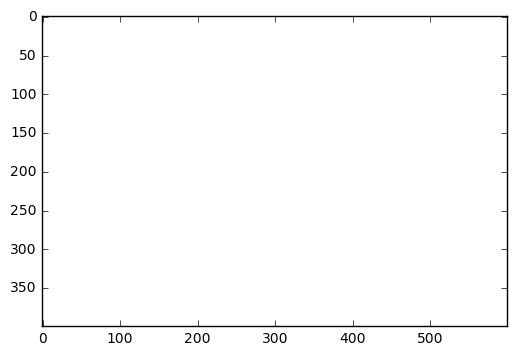

In [198]:
a = 'MetricsEpoch2.png'
plt.imshow(plt.imread(a))

---
<a name='c'/>
# Conclusions
</a>